# Gaussian Mixture Model Fitting
## Contents
1. [Generate mixture of Gaussians](#Generate-mixture-of-Gaussians)
2. [Initialize peaks](#Initialize-peaks)
3. [Fit model](#Fit-model)
3. [Compute errors](#Compute-errors)
4. [Dynamic process simulation](#Dynamic-process-simulation)

### Tests for determining ranges of parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Gaussian window

In [2]:
# from scipy import signal
# plt.plot(signal.gaussian(51, std=7, sym=True))

Gaussian function

In [3]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

parameters of gaussian **noise**

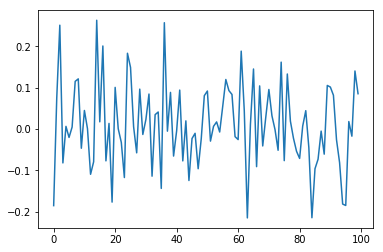

In [4]:
plt.plot(np.random.normal(0, 0.1, 100)) # mu, sig, size

range of **x** and **sigma**

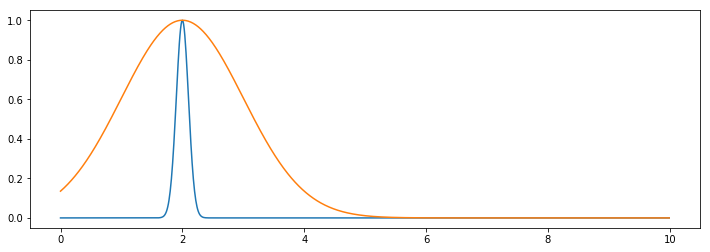

In [5]:
x = np.arange(0, 10, 0.01)
plt.figure(figsize=(12.0, 4.0)) # mpl.rcParams['figure.figsize']
plt.plot(x, gaussian(x, 2, 0.1))
plt.plot(x, gaussian(x, 2, 1))

## Generate mixture of Gaussians
### Generate MoG paramters
Number of peaks

In [6]:
params = {'n': 3}
n = params['n']

**mu**: $\mu \tilde{} \mathcal{U}(0,8)$

In [7]:
params['mu'] = np.random.uniform(0, 8, n)

**sigma**: $\sigma \tilde{} \mathcal{N}(0.5,0.2^2)$

In [8]:
params['sig'] = np.random.normal(0.5, 0.2, n)

**amplitude**(weight): $w \tilde{} \mathcal{U}(0.5,4)$

In [9]:
params['w'] = np.random.uniform(0.5, 4, n)

In [10]:
params

{'mu': array([1.0093493 , 1.41074445, 3.68446601]),
 'n': 3,
 'sig': array([0.38965011, 0.53216359, 0.48128138]),
 'w': array([2.95907851, 1.41572692, 0.62208509])}

Or mannually specify:

In [11]:
params = {'mu': np.array([2.34917627, 0.65435119, 5.72266429]),
          'sig': np.array([0.5400393 , 0.4009068 , 0.92974664]),
          'w': np.array([2.55892779, 1.34255752, 3.83689715]),
          'n': 3}

### Mixture of Gaussians

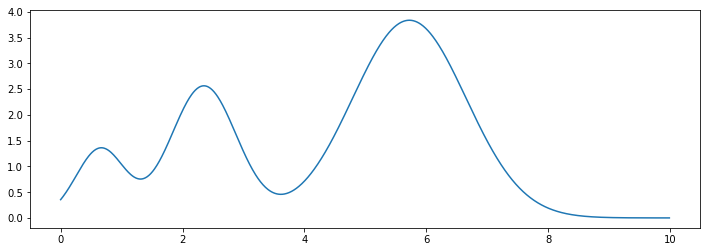

In [12]:
def MoG(params):
    return sum(params['w'][i] * gaussian(x, params['mu'][i], params['sig'][i]) for i in range(0, params['n']))
mog = MoG(params)
plt.figure(figsize=(12.0, 4.0))
plt.plot(x, mog)

Add noise: $\mathcal{N}(0,0.1^2)$

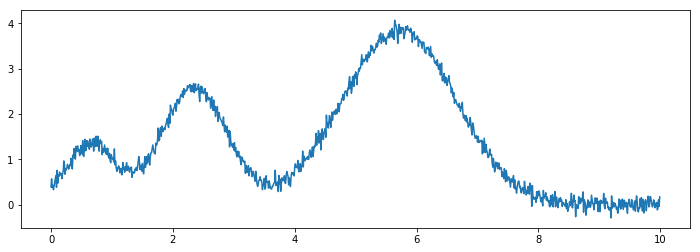

In [13]:
noise = np.random.normal(0, 0.1, len(mog))
mogn = mog + noise
plt.figure(figsize=(12.0, 4.0))
plt.plot(x, mogn)

## Initialize peaks
Manually specify peaks.

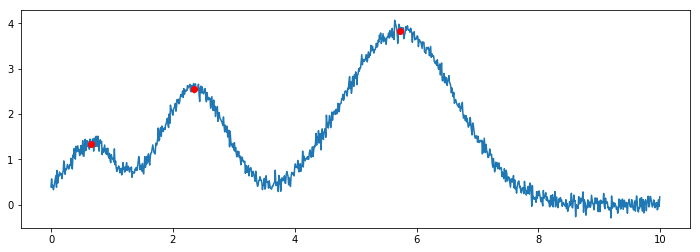

In [14]:
peaks = np.array([[0.65, 2.35, 5.72],  # x
                  [1.34, 2.56, 3.84]]) # y
plt.figure(figsize=(12.0, 4.0))
plt.plot(x, mogn)
plt.plot(peaks[0], peaks[1], 'ro')

## Fit model
### Initialize model

In [15]:
from lmfit.models import ConstantModel, GaussianModel

In [16]:
mod = ConstantModel() # Model
pars = mod.make_params() # Parameters([('c', <Parameter 'c', 0.0, bounds=[-inf:inf]>)])

Update model by adding **MoG**.

In [17]:
for i in range(peaks.shape[1]):
    gmod = GaussianModel(prefix='g'+str(i+1)+'_')
    pars.update(gmod.make_params(center=peaks[0,i], 
                                 amplitude=peaks[1,i]-pars['c']))
    mod += gmod

### Fit model

In [18]:
init = mod.eval(pars, x=x) # init guess

In [19]:
out = mod.fit(data=mogn, params=pars, x=x) # fit model

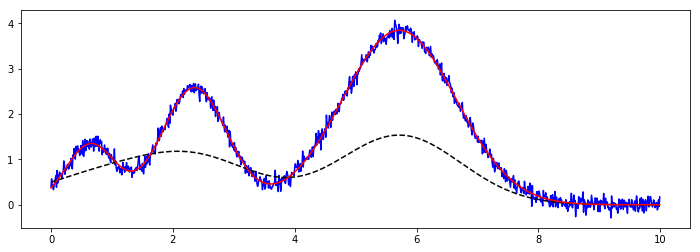

In [20]:
plt.figure(figsize=(12.0, 4.0))
plt.plot(x, out.data, 'b')          # original data
plt.plot(x, out.init_fit, 'k--')    # initial fit
plt.plot(x, out.best_fit, 'r-')     # best fit

## Compute errors
squared residuals (chi-square)

In [21]:
print(out.fit_report(min_correl=0.5))

[[Model]]
    (((Model(constant) + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 108
    # data points      = 1000
    # variables        = 10
    chi-square         = 9.52712754
    reduced chi-square = 0.00962336
    Akaike info crit   = -4633.61202
    Bayesian info crit = -4584.53447
[[Variables]]
    c:            -0.00108526 +/- 0.00714933 (658.76%) (init = 0)
    g1_sigma:      0.40698087 +/- 0.00694132 (1.71%) (init = 1)
    g1_center:     0.64959890 +/- 0.00577242 (0.89%) (init = 0.65)
    g1_amplitude:  1.36185992 +/- 0.02174776 (1.60%) (init = 1.34)
    g1_fwhm:       0.95836669 +/- 0.01634556 (1.71%) == '2.3548200*g1_sigma'
    g1_height:     1.33496086 +/- 0.01610563 (1.21%) == '0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'
    g2_sigma:      0.53443085 +/- 0.00384183 (0.72%) (init = 1)
    g2_center:     2.35181859 +/- 0.00333424 (0.14%) (init = 

## Dynamic process simulation
Parameters from the result of last fitting will be used as initial parameters of the current model fitting.

### Simulate changes of input data

In [22]:
def alter(old_params):
    new_params = old_params.copy()
    for key, vals in new_params.items():
        if key == 'n':
            continue
        scale = 0.05 if key == 'sig' else 0.1
        for i in range(len(vals)):
            vals[i] += np.random.normal(0, scale)
    return new_params

### Dynamic fitting

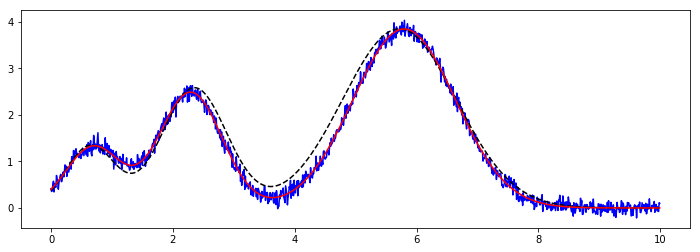

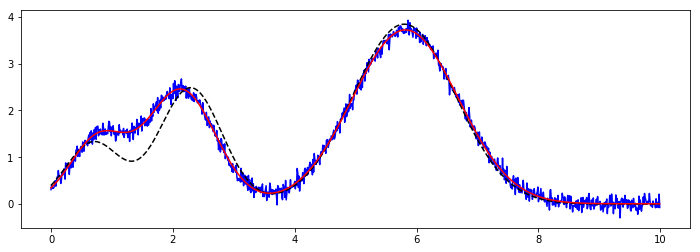

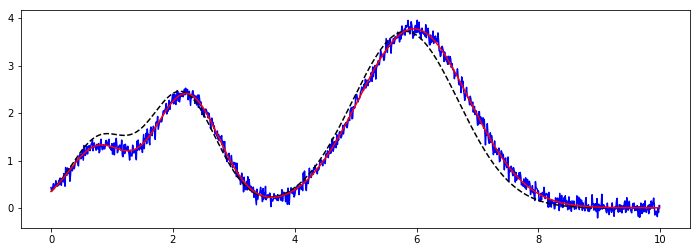

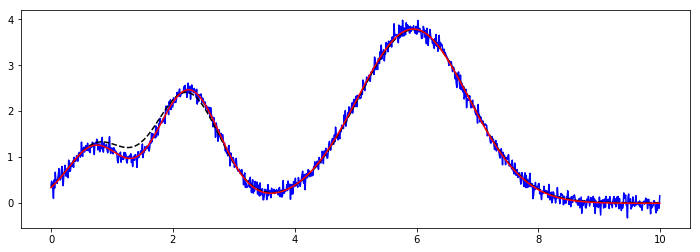

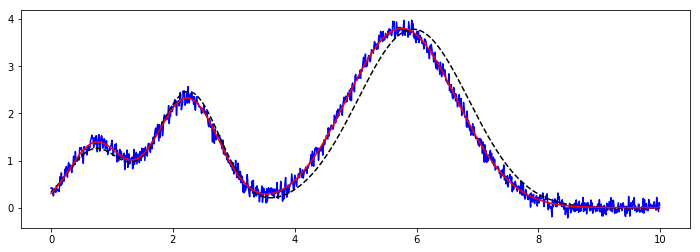

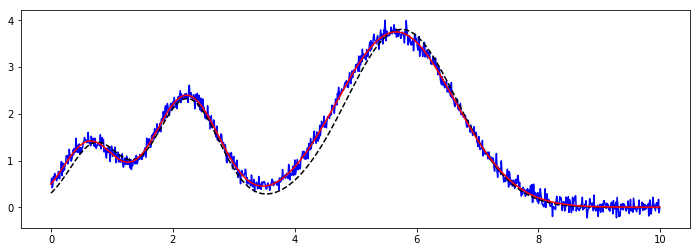

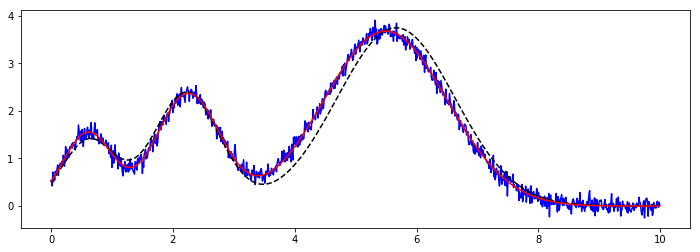

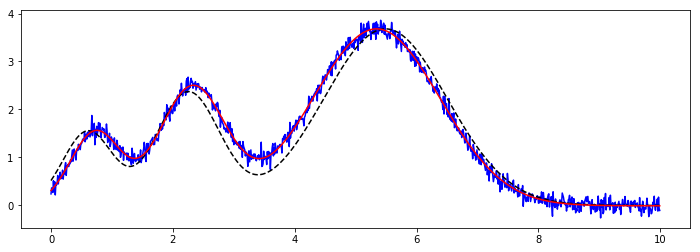

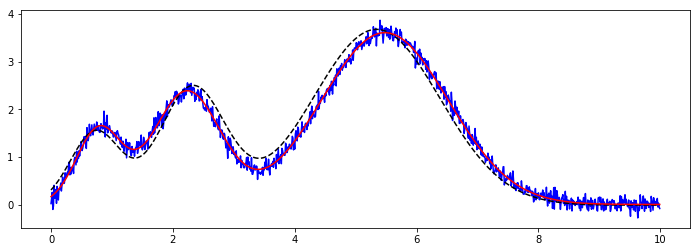

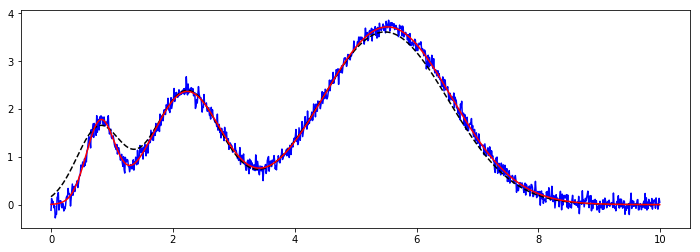

In [23]:
out_c = out
params_c = params
for i in range(10):
    params_c = alter(params_c)
    data = MoG(params_c)
    data = data + np.random.normal(0, 0.1, len(data))
    # fit
    out_c = mod.fit(data, out_c.params, x=x)
    # plot
    plt.figure(figsize=(12.0, 4.0))
    plt.plot(x, out_c.data, 'b')          # original data
    plt.plot(x, out_c.init_fit, 'k--')    # initial fit
    plt.plot(x, out_c.best_fit, 'r-')     # best fit
    # errors
    #print("chi-square =", out_c.chisqr)